## Bergfex Webscraping
<b> Milestone 3</b> 

In this part of our project, our aim is to find the nearest known snow level (from a list of observation stations reported by meteocentrale) for the activities and to create a "snow alert" if necessary. Therefore, we use the files from Milestones 1 & 2 and compare the GPS coordinates. 
We then classify based on two conditions if a snow alert exists or not. Finally, we add the 'snow status' to each activity.

### Imports

In [1]:
import pandas as pd
import numpy as np

# geodata processing packages
import shapely
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points
import geopy.distance

import matplotlib
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pyplot as plt

# 1 Importing existing files
First of all, we import the previously created files that contain all the scraped activities and the scraped snow level information.

In [2]:
# change the file_path to your path if necessary
filepath = '../data/'

# importing activity data
activities = pd.read_csv(filepath + 'activities_all_gpx.csv')

# importing snow level data merged with cities coordinates
snow = pd.read_csv(filepath + 'snow_coordinates.csv', sep=';', decimal=',')
snow = snow.dropna() 

# renaming the snow columns for later merging with the coordinates of the activity_df
snow = snow.rename(columns = {'lat':'snow_obs_lat', 'lng':'snow_obs_lng'})
snow = snow.rename(columns = {'location':'snow_obs_location', 'height_in_m':'snow_obs_alt'})
snow.head()

,snow_obs_location,snow_obs_alt,snowlevel_in_cm,snow_obs_lat,snow_obs_lng
2,Aigle,381,0,46.319025,6.970566
3,Altdorf,449,0,46.880600,8.639400
4,Andermatt,2282,0,46.602389,8.611800
5,Appenzell,780,0,47.333300,9.416700
6,Beatenberg,1182,0,46.703541,7.809551


# 2 Compare hike location and snow level location
Now, we want to calculate the closest point in that snow df to another GPS point from the activities df.
Shapely works with 3D geodata as "Point objects" for single localisations, and "Multipoint objects" for extended coverage data (similar to a grid).

- <b>1st step</b>: making Point objects out of the snow_points observation locations
- <b>2nd step</b>: joining all the snow_points into a Multipoint object

In [3]:
snow_point_list= [] # list that contains all the snow points in Point object format

# Iterating through all snow locations and creating a point made of lat & lon
for index, row in snow.iterrows():
    point = Point(row['snow_obs_lat'], row['snow_obs_lng'])
    snow_point_list.append(point)
    
len(snow_point_list) # 48 locations

# Creating a MultiPoint / Grid
snow_grid = MultiPoint(snow_point_list)

In [4]:
len(snow_point_list), snow_point_list[:5]

(48,
  <shapely.geometry.point.Point at 0x7fb7ec061670>])

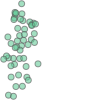

In [5]:
snow_grid

In [6]:
nearest_list = [] # list that contains tuples of nearest snow points in Point object format
near_lng = []  # contains the longitudes of the nearest snow point extracted from nearest shapely calculation
near_lat = []  # contains the latitudes of nearest snow point

# Finding which snow point is nearest to the test point 
for index, row in activities.iterrows():
    tested_point = Point(row['lat'], row['lon']) # iterates through each row of 'activities'
    nearest = nearest_points(tested_point, snow_grid) # records the nearest match from the snow_grid
    nearest_list.append(nearest[1]) # the second item in the tuple is the nearest point

# Saving longitude & latitude of the nearest snow point in lists 
for i in range(len(nearest_list)):
    near_lng.append(nearest_list[i].y) 
    near_lat.append(nearest_list[i].x)

In [7]:
len(nearest_list), nearest_list[:5]

(542,
  <shapely.geometry.point.Point at 0x7fb7ee0666a0>])

In [8]:
nearest_list[0].y, nearest_list[0].x

(7.570987799999999, 47.5378697)

In [9]:
# Test: dataframe output works for each row of trails
# should not return an error
assert len(near_lng) == len(activities)

Now, we need to match those calculated nearest coordinates
with the name of the snow_point with same coordinate. 
We merge the two dataframes on coordinates, with replicating 
the rows of snow points if necessary.

In [10]:
# Adding the coordinates of the nearest snow point to each 'activity'
activities['snow_obs_lat'] = near_lat
activities['snow_obs_lng'] = near_lng

# Merged 'snow' with 'activity' (expected len is length of 'activity')
merged = pd.merge(activities, snow, on=['snow_obs_lat','snow_obs_lng'])
merged.head()

,ID,title,difficulty,sport,length,time,climb,min,max,technique,...,region,trail_id,name,lat,lon,snow_obs_lat,snow_obs_lng,snow_obs_location,snow_obs_alt,snowlevel_in_cm
0,129549,Bornkänzeli,2 - medium,Hiking,10.30,03:00,318,392,665.0,2,...,aargau,129549,Bornkänzeli,47.320610,7.907470,47.53787,7.570988,Binningen,316,0
1,129607,Aarelauf,2 - medium,Hiking,11.34,02:30,75,391,428.0,2,...,aargau,129607,Aarelauf,47.320610,7.907470,47.53787,7.570988,Binningen,316,0
2,961881,Hüslischnegg am Asperstrihen,2 - medium,Hiking,5.00,01:23,173,670,804.0,3,...,aargau,961881,Hüslischnegg am Asperstrihen,47.436832,8.029861,47.53787,7.570988,Binningen,316,0
3,129624,Rundwanderung Engelberg,2 - medium,Hiking,11.17,03:30,283,395,702.0,1,...,aargau,129624,Rundwanderung Engelberg,47.320080,7.899660,47.53787,7.570988,Binningen,316,0
4,897134,PanoramatourAG-Strihen-ZeiherHomberg,1 - easy,Mountainbike,25.29,01:31,756,438,740.0,1,...,aargau,897134,PanoramatourAG-Strihen-ZeiherHomberg,47.462158,7.996060,47.53787,7.570988,Binningen,316,0


# 3 Calculate the snow alert

## Condition 1: Relevance of snow level
We want to make sure our snow level is actually relevant: 
The snow point has to be less than 30 km away from the hike (30 km is in between the average resolution of the snow thickness maps of SLF ('Schnee- und Lawinenforschung'), the high resolution being 2-5 km, the larger one around 50 km).

For raster data see https://www.slf.ch/de/lawinenbulletin-und-schneesituation/schneekarten.html

In [11]:
# Calculating the distance between gps point and nearest point
distance = []  # contains the distances in km from snow measurement to hike start
for index, row in merged.iterrows(): # iterating through merged df
    gps_coords = (row['lat'], row['lon'])
    snow_coords = (row['snow_obs_lat'], row['snow_obs_lng'])
    d = round(geopy.distance.geodesic(gps_coords, snow_coords).km, 1)
    distance.append(d)

# Append distance to df and assign status
merged['distance'] = distance
merged['snow_status'] = 'check for yourself' # starting with a default status
merged.loc[merged['distance'] > 30, 'snow_status'] = 'No local data'
merged['snow_status'].unique() #for now only 'No local data', 'check for yourself'

array(['No local data', 'check for yourself'], dtype=object)

## Condition 2: Difference in Altitude
 i.e. altitude difference should be <1000m (order of magnitude for data reported by SLF). 

 We process each possible case separately:
- #1: if the snow measurement was done more than 1000 m lower than the max alt of the hike, we want a warning saying potential snow
- #2: if the measurement is more than 1000 m higher than the max alt, we want a message saying the hike is low altitude
- #3: if any snow point in a radius of 30 km of a lower altitude has snow, we want a snow warning
- #4: if the measurement is within 1000 m up and down of the highest point, we consider it accurate

In [12]:
# 'Snow' if max alt of the hike within 1000m vertical radius of snow point, otherwise 'check for yourself'
merged.loc[(merged['snowlevel_in_cm'] > 0) & (
    merged['max'] + 1000 > merged['snow_obs_alt']), 'snow_status'] = 'Snow'

# 'No snow' if there is no snow and the max alt is <1000m over the snow point, otherwise 'check for yourself'
merged.loc[(merged['snowlevel_in_cm'] == 0) & (
    merged['max'] <= merged['snow_obs_alt'] + 1000), 'snow_status'] = 'No Snow'

# 'No local data' if there is no snow and the max hike alt is >1000m over the snow point
merged.loc[(merged['snowlevel_in_cm'] == 0) & (
    merged['max'] > merged['snow_obs_alt'] + 1000), 'snow_status'] = 'No local data'

# if any snow point in a radius of 30 km of a lower altitude has snow, we want a snow warning
# if the measurement is within 1000 m up and down of the highest point, we consider it accurate

# drop Unnamed column (unhash if necessary)
#merged = merged.drop(columns = ['Unnamed: 0']) 
merged['snow_status'].unique(), merged

(array(['No Snow', 'No local data', 'Snow'], dtype=object),
          ID                                              title     difficulty  \
 0    129549                                        Bornkänzeli     2 - medium   
 1    129607                                           Aarelauf     2 - medium   
 2    961881                       Hüslischnegg am Asperstrihen     2 - medium   
 3    129624                            Rundwanderung Engelberg     2 - medium   
 4    897134               PanoramatourAG-Strihen-ZeiherHomberg       1 - easy   
 ..      ...                                                ...            ...   
 537  707118  Rundwanderung von der Fiescheralp durch den Tä...     2 - medium   
 538  819423  Vom Mattmark-Stausee zur goldenen Madonna auf ...     2 - medium   
 539  130874               Maultierweg / Alter Saumweg Saas-Fee       1 - easy   
 540   50737                       Via ferrata Mammut - Route C     2 - medium   
 541   61913                          

Let's check how many activities are under snow alert!

In [13]:
snow_alert_act = merged[merged['snow_status'] == 'Snow']
snow_alert_act

,ID,title,difficulty,sport,length,time,climb,min,max,technique,...,name,lat,lon,snow_obs_lat,snow_obs_lng,snow_obs_location,snow_obs_alt,snowlevel_in_cm,distance,snow_status
312,870922,Gehrihorn,1 - easy,Hiking,6.65,03:20,1357,771,2129.0,1,...,Gehrihorn,46.588749,7.651042,46.472472,7.546399,Chuenisbaergli-Schneehoehe,0,3,15.2,Snow
313,99640,Rund ums Wiriehore,2 - medium,Hiking,9.20,03:30,622,1410,2032.0,4,...,Rund ums Wiriehore,46.599850,7.535519,46.472472,7.546399,Chuenisbaergli-Schneehoehe,0,3,14.2,Snow
314,316229,Gipfelwanderung zum Rauflihorn,2 - medium,Hiking,15.33,06:00,1101,1222,2323.0,3,...,Gipfelwanderung zum Rauflihorn,46.565910,7.479245,46.472472,7.546399,Chuenisbaergli-Schneehoehe,0,3,11.6,Snow
315,700232,Rundtour über den Rüwlispass - Hornberg ins Sa...,2 - medium,Cycling,31.82,03:25,950,934,1836.0,2,...,Rundtour über den Rüwlispass - Hornberg ins Sa...,46.505466,7.400690,46.472472,7.546399,Chuenisbaergli-Schneehoehe,0,3,11.8,Snow
316,717203,Boltigen - Feuersteini - Rossberg - Pfaffenrie...,1 - easy,Cycling,15.91,01:25,405,797,1136.0,1,...,Boltigen - Feuersteini - Rossberg - Pfaffenrie...,46.627483,7.389884,46.472472,7.546399,Chuenisbaergli-Schneehoehe,0,3,21.0,Snow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,692222,Abstieg Trifthutte,2 - medium,Hiking,7.58,02:47,52,1356,2504.0,3,...,Abstieg Trifthutte,46.677834,8.376203,46.572520,8.333860,Grimsel-Hospiz,1980,1,12.1,Snow
485,85374,Biketour Gämschfax,2 - medium,Mountainbike,30.48,03:47,1048,1345,2239.0,2,...,Biketour Gämschfax,46.531616,8.342936,46.572520,8.333860,Grimsel-Hospiz,1980,1,4.6,Snow
529,51128,Chemin de pionniers - Vue des Alpes,2 - medium,Hiking,15.45,04:45,500,743,1307.0,3,...,Chemin de pionniers - Vue des Alpes,47.047291,6.873959,47.099600,6.829600,La Chaux-de-Fonds,1019,1,6.7,Snow
530,51604,Pâturages boisés du Jura neuchâtelois,2 - medium,Hiking,16.85,04:30,550,1003,1309.0,2,...,Pâturages boisés du Jura neuchâtelois,47.098202,6.826451,47.099600,6.829600,La Chaux-de-Fonds,1019,1,0.3,Snow


## Write CSV

In [14]:
merged.to_csv(filepath + 'activities_snow_alert.csv', index = False)

This is the end of this project.
Please do check out our next project where we create a dashboard in Tableau to visualize and select the activities. You will also learn how to create plots and dashboards in Tableau.
https://github.com/SarahDutschke/bergfex_snowalert_part_II

# The End